In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii


In [2]:
bounds = pickle.load(open('./pickle/bounds.pk','rb'))
master_cat = pd.read_csv('./catdata/master_catalog_jan_2023.csv') #2184 objects long

In [3]:
object_matches = pickle.load(open('./pickle/matches/matches_delta005_0802.pk','rb'))

In [4]:
cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']

In [5]:
def load_cat(field):
    bounds = [50,100,150,200,235,257,279,320,360,406]
    for b in range(len(bounds)):
        if field <= bounds[b]:
            to_load = cat_files[b]
            break
    print(f'Loading {to_load} ...')
    catalogue = pickle.load(open(f'./pickle/{to_load}','rb'))
    return catalogue

### Make regions test

#### Example field 43, HM33-C

In [17]:
object_matches[43]

[(222746, 2652)]

In [22]:
master_cat.loc[2652]

ID                   HM33-D
RADEG             23.759167
DECDEG             31.23925
CLASS                   1.0
DATATABLE    huxor09_table1
Name: 2643, dtype: object

In [16]:
f43 = load_cat(43)

Loading cat1_50.pk ...


In [21]:
f43[43][222746]

RA,Dec,iccd,xg,yg,g,dg,ig,xi,yi,i,di,ii,ia,field
float32,float32,uint8,float32,float32,float32,float32,int8,float32,float32,float32,float32,int8,int8,uint16
24.310274,31.074358,29,737.37,4151.59,20.897,0.004,1,736.76,4149.76,19.664,0.004,1,0,43


In [24]:
## create DS9 regions to try and identify RBC objects
radius = '20.0"'
hm33d = master_cat.loc[2643]

with open('./ds9_regions/hm33-d.reg', 'w') as f:
    f.write('global color=red dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
    f.write('fk5 \n')
    ra = str(hm33d.RADEG)
    dec = str(hm33d.DECDEG)
    f.write('circle('+ra+','+dec+','+radius+') \n')

# Make regions from predictions

In [12]:
def make_reg_from_pred(field:int,date='2802'):
    predictions = pickle.load(open(f'pickle/predictions/{date}/predictionsf{field}.pk','rb'))
    gcs = predictions[predictions['pred']=='gc']
    radius = '16"'
        
    with open(f'./ds9_regions/predictions/{date}/{field}_predictions.reg','w') as f:
        f.write('global color=green dashlist=8 3 width=1 font="helvetica 14 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
        f.write('fk5 \n')
        for row in gcs:
            ra = str(row['RA'])
            dec = str(row['Dec'])
            f.write(f'circle({ra},{dec},{radius}) \n')

In [14]:
fields = [34,35,36,53,56,59,63,78,80,103,101,99,148,146,85,88,86,5,162,135,188,186,184,185,169]
fields = [196,240,220,241,243,310,333]
for f in fields:
    print(f)
    make_reg_from_pred(f)

196
240
220
241
243
310
333


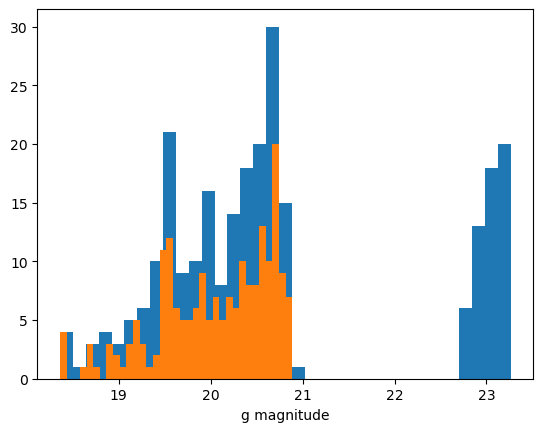

255


In [11]:
field=135
predictions = pickle.load(open(f'pickle/predictions/predictionsf{field}.pk','rb'))

gcs = predictions[predictions['pred']=='gc']
gcs_44 = gcs[(gcs['g']+gcs['i']<44)]# & (gcs['g']+gcs['i'] > 25)]

plt.hist(gcs['g'],bins=35)

#plt.hist(gcs[gcs['g']+gcs['i']<44]['g'],bins=35)
plt.hist(gcs_44['g'],bins=35)

plt.xlabel('g magnitude')
plt.show()
gcs_reg = gcs

radius = '15"' # 0.006 degrees
    
with open(f'./ds9_regions/predictions/{field}_predictions.reg','w') as f:
    f.write('global color=green dashlist=8 3 width=1 font="helvetica 14 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
    f.write('fk5 \n')
    for row in gcs_reg[::]:
        ra = str(row['RA'])
        dec = str(row['Dec'])
        
        f.write(f'circle({ra},{dec},{radius}) \n')
print(len(gcs))

# Make regions from region_data
Using output from catalog_matching.ipynb, build region files.

In [7]:
f'./pickle/region_data/{cat_files[0][:-3]}_region_data.pk'

'./pickle/region_data/cat1_50_region_data.pk'

In [9]:
region_data = pickle.load(open(f'./pickle/region_data/{cat_files[0][:-3]}_region_data.pk','rb'))

In [65]:
master_cat.loc[2319:2321]

,ID,RADEG,DECDEG,CLASS,DATATABLE
2319,LAMOST-C22,11.738630,29.693500,4.0,NaN
2320,LAMOST-C22,11.738630,29.693500,4.0,NaN
2321,B391,11.742112,41.565697,1.0,m31rbcV5


In [73]:
master_cat[master_cat.ID == obj[0]].reset_index().loc[0].CLASS

4.0

In [74]:
radius = '21.6"' # 0.006 degrees
for cat_f in cat_files:
    region_data = pickle.load(open(f'./pickle/region_data/{cat_f[:-3]}_region_data.pk','rb'))
    
    for c in region_data:
        reg = region_data[c]
        if reg == []: continue # if there are no objects in the field, continue
        print(c)
        with open(f'./ds9_regions/{c}.reg','w') as f:
            f.write('global color=red dashlist=8 3 width=1 font="helvetica 14 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
            f.write('fk5 \n')
            for obj in reg:
                ra = str(obj[1])
                dec = str(obj[2])
                pts = obj[3]
                class_ = master_cat[master_cat.ID == obj[0]].reset_index().loc[0].CLASS
                f.write(f'circle({ra},{dec},{radius}) # text={{{obj[0]}, {len(pts)} pts, class {class_}}} \n')
                
                for p in pts[::2]:
                    f.write(f'point{str(p)} # color=green \n')

5
11
13
14
20
22
24
25
26
30
33
35
37
43
52
58
62
70
80
81
82
84
85
91
92
94
95
97
102
111
114
124
125
126
128
138
139
142
146
148
153
162
165
167
169
173
180
183
184
185
186
187
188
189
196
201
204
205
207
208
209
210
211
212
214
220
223
224
225
227
228
229
231
232
233
234
235
238
240
241
243
248
249
253
254
255
256
257
261
263
265
266
268
269
274
275
276
277
278
279
280
282
285
286
287
293
294
295
296
297
301
303
304
306
307
310
316
317
319
321
327
328
333
334
335
336
338
339
340
341
342
347
348
351
362
368
375
379
390
391
392
395
398
402



## Make all regions

Make one region file for field 43

In [ ]:
## create DS9 regions to try and identify RBC objects
radius = '21.6"'


with open('./ds9_regions/43.reg', 'w') as f:
    f.write('global color=red dashlist=8 3 width=1 font="helvetica 14 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
    f.write('fk5 \n')
    for o in in_field:
        ra = str(o.RADEG)
        dec = str(o.DECDEG)
        f.write('circle('+ra+','+dec+','+radius+') # text={hm33d} \n')
    for o in obj_del.index:
        
        ra = str(CAT[43][o]['RA'])
        dec = str(CAT[43][o]['Dec'])
        f.write('point('+ra+','+dec+') # color=green \n')

In [ ]:
for f in cat_files:
    print(f'\n{f}')
    CAT = pickle.load(open(f'./pickle/{f}','rb'))
    
    for c in CAT:
        print(f'Field {c}')
        idx,d2d = match_objs(c)
        objs = set(idx)
        d2d = d2d.degree
        
        d2d_idx_tuples = [(d2d[i],idx[i]) for i in range(len(d2d))]
        
        d2d_idx_df = pd.DataFrame(d2d_idx_tuples, columns=['d2d','idx'])
        
        # get the list of all obj from master_cat which are in the field CAT[c]
        in_field = find_objs_in_field(c,objs)
        delta = 0.006 # the size of the region in which to determine crowding ~22 arc
        matches[c] = find_closest_match(c, in_field, crowding_limit=100, delta=delta)
print('Done!')